## Download the dataset

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Analyze the data

In [3]:
# Download housing data and load into panda
fetch_housing_data()
housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Check categories of ocean_proximity
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# describe shows a summary of the numerical attribtues
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Plot the data

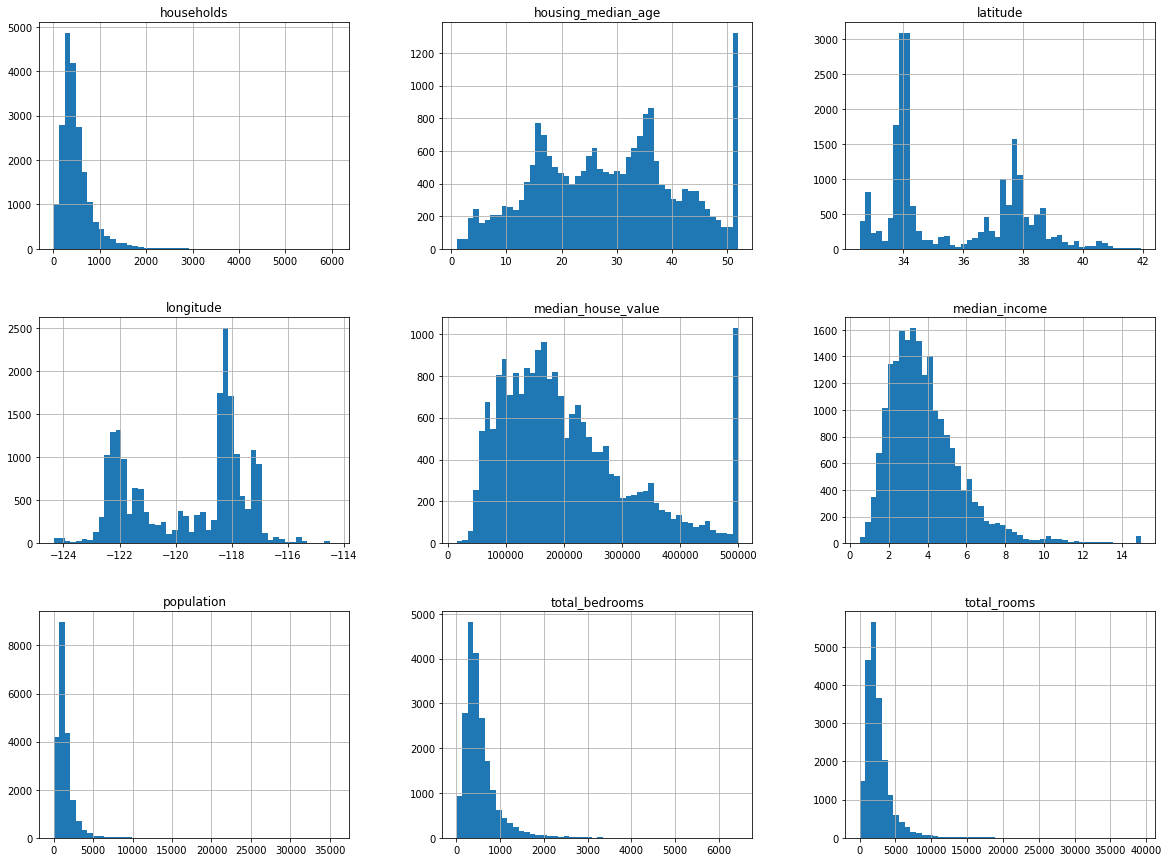

In [8]:
# only in a jupyter notebook to show the plots in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## Various ways to split the data

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print("{0} train + {1} test".format(len(train_set), len(test_set)))

16512 train + 4128 test


In [11]:
# To keep the a seperate test set even when the root data is updated.
# Compute a hash of each instance's identifier, keep only the last byte of the hash, 
# and put the instance in the test set if this value is lower or equal to 51 (~20% of 256).
# This ensures that the test set will reamin consistens across multiple runs, even after refreshing the dataset.
# The new test set will containt 20% of the new instances, but will not contain any instance that was previously
# in the training set.

import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.sha256):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print("{0} train + {1} test".format(len(train_set), len(test_set)))

16493 train + 4147 test


In [12]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
14,14,-122.26,37.85,52.0,2643.0,626.0,1212.0,620.0,1.9167,159200.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
18,18,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY
26,26,-122.28,37.85,49.0,1130.0,244.0,607.0,239.0,2.4597,93800.0,NEAR BAY


In [14]:
# Another method for splitting using scikit learn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print("{0} train + {1} test".format(len(train_set), len(test_set)))

16512 train + 4128 test


In [15]:
# Create stratas for income
# The following code creates an income category by dividing the median income by 1.5 (to limit th number of income categories)
# Rounding up using 'ceil' to create discrete categories and then merging all the categories greather than 5 into category 5.

housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing['income_cat'].head()

0    5.0
1    5.0
2    5.0
3    4.0
4    3.0
Name: income_cat, dtype: float64

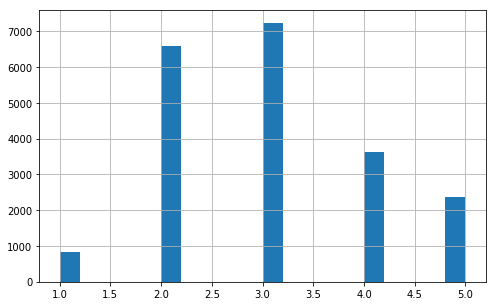

In [16]:
%matplotlib inline 
housing['income_cat'].hist(bins=20, figsize=(8,5))
plt.show()

In [17]:
# Do stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [18]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
strat_test = strat_test_set['income_cat'].value_counts() / len(strat_test_set)
random_test = test_set['income_cat'].value_counts() / len(test_set)
overall = housing['income_cat'].value_counts() / len(housing)

print('Sampling bias comparison')
df = pd.DataFrame({"Stratified": strat_test, "Overall": overall, "Random": random_test, "Rand. %error": 100*(random_test-overall)/overall, "Strat. %error": 100*(strat_test-overall)/overall}).sort_index()
df

Sampling bias comparison


,Overall,Rand. %error,Random,Strat. %error,Stratified
1.0,0.039826,0.973236,0.040213,-0.243309,0.039729
2.0,0.318847,1.732260,0.324370,-0.015195,0.318798
3.0,0.350581,2.266446,0.358527,-0.013820,0.350533
4.0,0.176308,-5.056334,0.167393,0.027480,0.176357
5.0,0.114438,-4.318374,0.109496,0.127011,0.114583


In [19]:
# Remove income category
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Discover and visualize the data to gain insights

In [20]:
# Create a copy of the training set for tests and manipulations
housing = strat_train_set.copy()

### Visualising Geographical Data

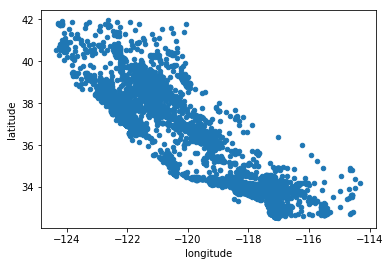

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude")

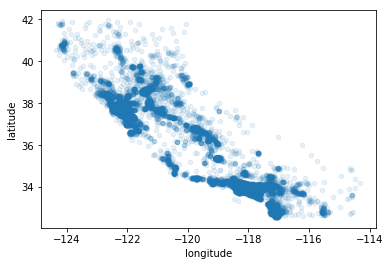

In [22]:
# Changing the alpha value to discern places of high density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

### Looking at housing prices with detailed graph

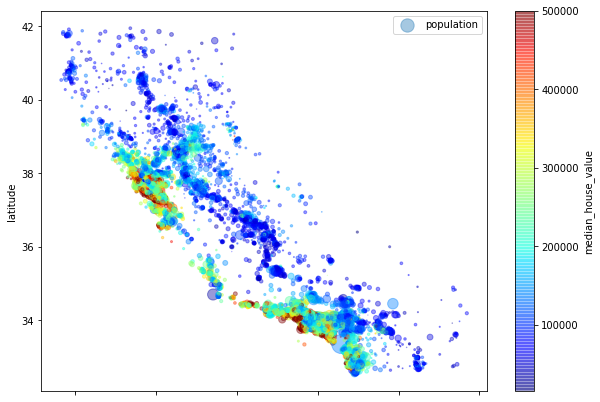

In [23]:
# The radius of each circle represents the district's population, and the color represents the price.
# Blue = low values, Red = high values

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
             s=housing['population']/100, 
             label="population",
             figsize=(10,7),
             c="median_house_value",
             cmap=plt.get_cmap("jet"),
             colorbar=True)
plt.legend()

# Looking for correlations

In [24]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

## Another way to check for correlation between attributes is to use Pandas' scatter_matrix function to plot every numerical attribute against every other numerical attribute.

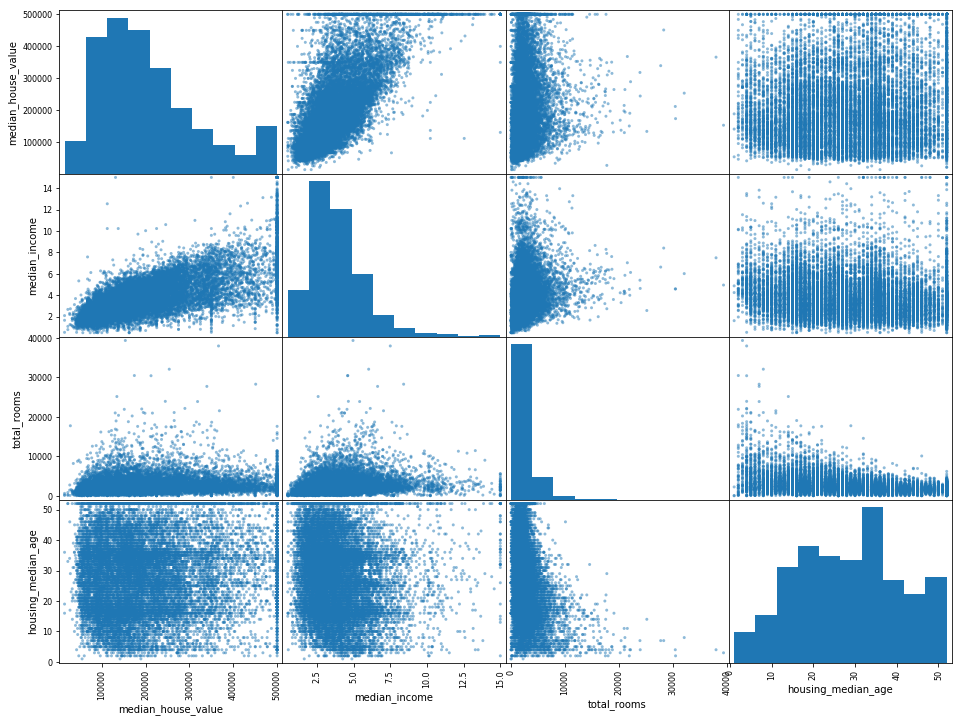

In [38]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
plot = scatter_matrix(housing[attributes], figsize=(16,12))


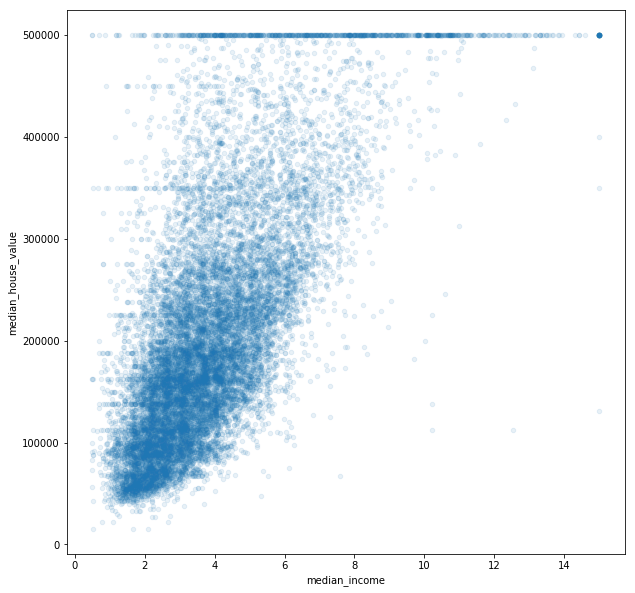

In [40]:
# The most promising correlation to predict the median house value seems to be the median income,
# so let's look closer at that.

plot = housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(10,10))